In [1]:
# train_utils.py

import torch
from torch import nn
from torch.autograd import Variable
import copy
import math
import numpy 

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Embeddings(nn.Module):
    '''
    Usual Embedding layer with weights multiplied by sqrt(d_model)
    '''
    def __init__(self,embeddings ,d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        #self.lut = nn.Embedding.from_pretrained(embeddings, freeze=True)
        
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(torch.as_tensor(position.numpy() * div_term.unsqueeze(0).numpy()))
        pe[:, 1::2] = torch.cos(torch.as_tensor(position.numpy() * div_term.unsqueeze(0).numpy()))#torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)
    

In [2]:
# config.py

class Config(object):
    N = 6 #6 in Transformer Paper
    d_model = 512 #512 in Transformer Paper
    d_ff = 2048 #2048 in Transformer Paper
    h = 8
    dropout = 0.1
    output_size = 4
    lr = 0.0003
    max_epochs = 200
    batch_size = 1
    max_sen_len = 50

In [3]:
# attention.py

import torch
from torch import nn
import math
import torch.nn.functional as F


def attention(query, key, value, mask=None, dropout=None):
    "Implementation of Scaled dot product attention"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)

    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), self.h)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Multi-head attention"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [4]:
class Encoder(nn.Module):
    '''
    Transformer Encoder

    It is a stack of N layers.
    '''
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class EncoderLayer(nn.Module):
    '''
    An encoder layer

    Made up of self-attention and a feed forward layer.
    Each of these sublayers have residual and layer norm, implemented by SublayerOutput.
    '''
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(size, dropout), 2)
        self.size = size

    def forward(self, x, mask=None):
        "Transformer Encoder"
        x = self.sublayer_output[0](x, lambda x: self.self_attn(x, x, x, mask)) # Encoder self-attention
        return self.sublayer_output[1](x, self.feed_forward)

In [5]:
# sublayer.py

import torch
from torch import nn

class LayerNorm(nn.Module):
    "Construct a layer normalization module."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerOutput(nn.Module):
    '''
    A residual connection followed by a layer norm.
    '''
    def __init__(self, size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [6]:
# feed_forward.py

from torch import nn
import torch.nn.functional as F

class PositionwiseFeedForward(nn.Module):
    "Positionwise feed-forward network."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        "Implements FFN equation."
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [7]:
import pandas as pd
import json
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
def load_data_df(train_file):
    with open(train_file,'r') as f:
        intents = json.load(f)

    patterns = []
    tags = []
    max_len = 0
    for intent in intents['intents']:
        
        for pattern in intent['patterns']:
            if(len(pattern) < max_len):
                max_len = len(pattern)
            tag = intent['tag']
            tags.append(tag)
            patterns.append(pattern)

    
    full_df = pd.DataFrame({"text":patterns,"label":tags})
    #full_df['label'] = full_df['label'].apply(lambda x : x -1)
    train, test = train_test_split(full_df, test_size=0.4)
    return full_df,train, test , max_len

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import pandas as pd
import json
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
def load_data_df(train_file):
    with open(train_file,'r') as f:
        intents = json.load(f)

    patterns = []
    tags = []
    max_len = 0
    for intent in intents['intents']:
        
        for pattern in intent['patterns']:
            if(len(pattern) > max_len):
                max_len = len(pattern)
            tag = intent['tag']
            tags.append(tag)
            patterns.append(pattern)


    full_df = pd.DataFrame({"text":patterns,"label":tags})
    #full_df['label'] = full_df['label'].apply(lambda x : x -1)
    train, test = train_test_split(full_df, test_size=0.4)
    return full_df,train, test , max_len


# utils.py
from torchtext.vocab import FastText

import torch
import torchtext
from torchtext import data
from sklearn.metrics import accuracy_score,f1_score



class Dataset(object):
    def __init__(self, config):
        self.config = config
        self.full_iterator = None
        self.train_iterator = None
        self.test_iterator = None
        self.val_iterator = None
        self.vocab = []
        self.word_embeddings = {}
        self.output_num = None

    def parse_label(self, label):
        '''
        Get the actual labels from label string
        Input:
            label (string) : labels of the form '__label__2'
        Returns:
            label (int) : integer value corresponding to label string
        '''
        return int(label.strip()[-1])

    def get_pandas_df(self, filename):
        '''
        Load the data into Pandas.DataFrame object
        This will be used to convert data to torchtext object
        '''
        with open(filename, 'r') as datafile:
            data = [line.strip().split(',', maxsplit=1) for line in datafile]
            data_text = list(map(lambda x: x[1], data))
            print(len(data_text))
            data_label = list(map(lambda x: self.parse_label(x[0]), data))

        full_df = pd.DataFrame({"text":data_text, "label":data_label})
        return full_df

    def load_data(self, train_file, test_file=None, val_file=None):
        '''
        Loads the data from files
        Sets up iterators for training, validation and test data
        Also create vocabulary and word embeddings based on the data

        Inputs:
            train_file (String): path to training file
            test_file (String): path to test file
            val_file (String): path to validation file
        '''
        # Load data from pd.DataFrame into torchtext.data.Dataset
        full_df , train_df , test_df , max_len = load_data_df(train_file)
    

        NLP = spacy.blank('en')
        
        tokenizer = lambda sent: [x.text for x in NLP.tokenizer(sent) if x.text != " "]

        # Creating Field for data
        TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True,fix_length=self.config.max_sen_len, include_lengths=False)
        LABEL = data.Field(sequential=False, use_vocab=False)
        datafields = [("text",TEXT),("label",LABEL)]

   
        self.output_num = len(full_df.label.unique())

        full_examples = [data.Example.fromlist(i, datafields) for i in full_df.values.tolist()]
        full_data = data.Dataset(full_examples, datafields)
        
        train_examples = [data.Example.fromlist(i, datafields) for i in train_df.values.tolist()]
        train_data = data.Dataset(train_examples, datafields)


        test_examples = [data.Example.fromlist(i, datafields) for i in test_df.values.tolist()]
        test_data = data.Dataset(test_examples, datafields)

        # If validation file exists, load it. Otherwise get validation data from training data
        if val_file:
            val_df = self.get_pandas_df(val_file)
            val_examples = [data.Example.fromlist(i, datafields) for i in val_df.values.tolist()]
            val_data = data.Dataset(val_examples, datafields)
        else:
            train_data, val_data = train_data.split(split_ratio=0.8)

        #TEXT.build_vocab(train_data, vectors=FastText('simple'))
        TEXT.build_vocab(full_data, vectors=FastText('simple'))
        
        #TEXT.build_vocab(train_data,vectors=torchtext.vocab.GloVe(name="6B", dim=300, max_vectors=512),max_size=512, min_freq=2)
        self.vocab = TEXT.vocab

        self.full_iterator = data.BucketIterator(
            (full_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=True)
        
        self.train_iterator = data.BucketIterator(
            (train_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=True)

        self.val_iterator, self.test_iterator = data.BucketIterator.splits(
            (val_data, test_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=False)
        

        print ("Loaded {} training examples".format(len(train_data)))
        print ("Loaded {} test examples".format(len(test_data)))
        print ("Loaded {} validation examples".format(len(val_data)))

def evaluate_model(model, iterator):
    all_preds = []
    all_y = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch.text.cuda()
        else:
            x = batch.text
        y_pred = model(x)
        predicted = torch.max(y_pred.cpu().data, 1)[1] + 1
        all_preds.extend(predicted.numpy())
        all_y.extend(batch.label.numpy())
    score = accuracy_score(all_y, np.array(all_preds).flatten())
    f1 = f1_score(all_y,np.array(all_preds).flatten(), average='macro')
    
    return score , f1

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Model.py

import torch
import torch.nn as nn
from copy import deepcopy


class Transformer(nn.Module):
    def __init__(self, config, src_vocab):
        super(Transformer, self).__init__()
        self.config = config

        h, N, dropout = self.config.h, self.config.N, self.config.dropout
        d_model, d_ff = self.config.d_model, self.config.d_ff

        attn = MultiHeadedAttention(h, d_model)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        position = PositionalEncoding(d_model, dropout)
        self.src_vocab = src_vocab
        self.encoder = Encoder(EncoderLayer(config.d_model, deepcopy(attn), deepcopy(ff), dropout), N)
        
        a = dataset.vocab.vectors.tolist()
        for i in range(len(a)):
            while(len(a[i])!=config.d_model):
                a[i].append(0)
                
        a= torch.tensor(a)
               
        self.src_embed = nn.Sequential(Embeddings(dataset.vocab,config.d_model, len(self.src_vocab)), deepcopy(position)) #Embeddings followed by PE

        # Fully-Connected Layer
        self.fc = nn.Linear(
            self.config.d_model,
            self.config.output_size
        )

        # Softmax non-linearity
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
    def forward(self, x):    
        
        embedded_sents = self.src_embed(x.permute(1,0)) # shape = (batch_size, sen_len, d_model)
        
        encoded_sents = self.encoder(embedded_sents)

        # Convert input to (batch_size, d_model) for linear layer
        
        
        final_feature_map = encoded_sents[:,-1,:]


        final_out = self.fc(final_feature_map)
        final_out = self.softmax(final_out)
        
        return final_out

    def add_optimizer(self, optimizer):
        self.optimizer = optimizer

    def add_loss_op(self, loss_op):
        self.loss_op = loss_op

    def reduce_lr(self):
        print("Reducing LR")
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
    def predict(self,text):
        y_pred = self.__call__(text)
        
        return y_pred
    
    def run_epoch(self, train_iterator, val_iterator, epoch):
        train_losses = []
        val_accuracies = []
        losses = []

        # Reduce learning rate as number of epochs increase


        for i, batch in enumerate(train_iterator):


            if torch.cuda.is_available():
                x = batch.text.cuda()
                y = (batch.label-1).type(torch.LongTensor)
                
            else:
                x = batch.text
                y = (batch.label-1).type(torch.LongTensor)
            
            y_pred = self.__call__(x)

            loss = self.loss_op(y_pred, y)
            self.optimizer.zero_grad()
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()

            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                print("\tAverage training loss: {:.5f}".format(avg_train_loss))
                losses = []

                # Evalute Accuracy on validation set
                val_accuracy,f1 = evaluate_model(self, val_iterator)
                print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                print("\tf1: {:.4f}".format(f1))
                
                self.train()

        return train_losses, val_accuracies
        
    def run_epoch2(self, train_iterator,val_iterator,epoch):
        losses = []
        for j in range(epoch):
            for i, batch in enumerate(train_iterator):
                if torch.cuda.is_available():
                    x = batch.text.cuda()
                    y = (batch.label-1).type(torch.LongTensor)                
                else:
                    x = batch.text
                    y = (batch.label-1).type(torch.LongTensor)

                y_pred = self.__call__(x)
                print([torch.argmax(y_pred, dim=1),y])
                loss = self.loss_op(y_pred, y)
                self.optimizer.zero_grad()
                
                loss.backward()
                
                self.optimizer.step()
            losses.append(loss.detach().numpy())  
            
            if (j+1) % 1 == 0:
                print (f'Epoch [{j+1}/{epoch}], Loss: {loss.item():.10f}')
                # Evalute Accuracy on validation set
                val_accuracy,f1 = evaluate_model(self, val_iterator)
                print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                print("\tf1: {:.4f}".format(f1))
                
                self.train()
                

                
        return losses
        

In [11]:
dataset.full_iterator

In [12]:
# import sys  
import torch.optim as optim
from torch import nn
import torch
import spacy
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
if __name__=='__main__':
    config = Config()
    config.batch_size =1
    config.d_ff = 1024
    config.lr = 0.0001
    config.max_epochs = 50
    dataset = Dataset(config)

    train_file = '/Users/mac/Desktop/test/test.json'
    dataset.load_data(train_file)
    dataset.config.output_size = dataset.output_num

    
    print(dataset.vocab.vectors.size())
    # Create Model with specified optimizer and loss function
    ##############################################################

    model = Transformer(config, dataset.vocab)
    
    #for p in model.parameters():
     #   if p.dim() > 1: nn.init.xavier_uniform(p)

    if torch.cuda.is_available():
        model.cuda()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    NLLLoss = nn.NLLLoss()
    model.add_optimizer(optimizer)
    model.add_loss_op(NLLLoss)
    ##############################################################

    train_losses = []
    val_accuracies = []

    for i in range(config.max_epochs):
        print ("Epoch: {}".format(i))
        train_loss,val_accuracy = model.run_epoch(dataset.full_iterator, dataset.val_iterator, i)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)

    train_acc,train_f1 = evaluate_model(model, dataset.train_iterator)
    val_acc,val_f1 = evaluate_model(model, dataset.val_iterator)
    test_acc,test_f1 = evaluate_model(model, dataset.test_iterator)

    print ('Final Training Accuracy: {:.4f}'.format(train_acc))
    print ('Final Training f1: {:.4f}'.format(train_f1))
    
    print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
    print ('Final Training f1: {:.4f}'.format(val_f1))

    print ('Final Test Accuracy: {:.4f}'.format(test_acc))
    print ('Final Training f1: {:.4f}'.format(test_f1))


Loaded 41 training examples
Loaded 34 test examples
Loaded 10 validation examples
torch.Size([218, 300])
Epoch: 0
	Average training loss: -0.06690
	Val Accuracy: 0.1000
	f1: 0.0556
Epoch: 1
	Average training loss: -0.02303
	Val Accuracy: 0.1000
	f1: 0.0333
Epoch: 2
	Average training loss: -0.05415
	Val Accuracy: 0.0000
	f1: 0.0000
Epoch: 3
	Average training loss: -0.01947
	Val Accuracy: 0.1000
	f1: 0.0455
Epoch: 4
	Average training loss: -0.95928
	Val Accuracy: 0.3000
	f1: 0.1167
Epoch: 5
	Average training loss: -0.93957
	Val Accuracy: 0.3000
	f1: 0.1182
Epoch: 6
	Average training loss: -0.01709
	Val Accuracy: 0.5000
	f1: 0.3000
Epoch: 7
	Average training loss: -0.99321
	Val Accuracy: 0.6000
	f1: 0.4167
Epoch: 8
	Average training loss: -0.99514
	Val Accuracy: 0.6000
	f1: 0.3939
Epoch: 9
	Average training loss: -0.99902
	Val Accuracy: 0.6000
	f1: 0.3939
Epoch: 10
	Average training loss: -0.99298
	Val Accuracy: 0.6000
	f1: 0.3889
Epoch: 11
	Average training loss: -0.98615
	Val Accuracy: 

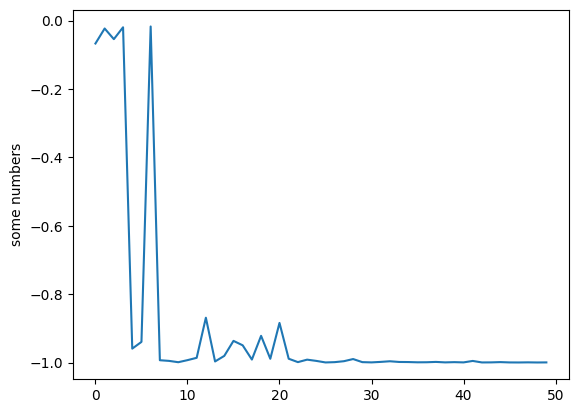

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_losses)

plt.ylabel('some numbers')
plt.show()

In [14]:
#SAVE MODEL

torch.save(model, '/Users/mac/Desktop/test/model.pth')



In [15]:


model= torch.load('/Users/mac/Desktop/test/model.pth')

model.eval()


Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-7): 8 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer_output): ModuleList(
          (0-1): 2 x SublayerOutput(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (src_embed): Sequential(
    (0): Embeddings(
      (lut): Embedding(218, 512)
    )
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=512, o

In [16]:
import torch
from collections import Counter
import random
import json
import spacy
def score_words(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  return intersection_cardinality/float(union_cardinality)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bot_name = "QP"
print("Hi! I am Fernando")
print("I am here to help you feel free to chat with me:-")
print("Let's chat! (type 'quit' to exit)")
print("Please write your question with keyword below")

with open('/Users/mac/Desktop/SCIENTIFIC RESEARCH/main QA.json', 'r') as json_data:
    main_intents = json.load(json_data)
corpse = []
responses = []
for intent in main_intents['intents']:
    tag = intent['tag']
    response = intent['responses']
    print(tag+"\n")
    corpse.append(tag)# here we are appending the word with its tag
    responses.append(response)

Hi! I am Fernando
I am here to help you feel free to chat with me:-
Let's chat! (type 'quit' to exit)
Please write your question with keyword below
requirement

scholarships

batchmates

language

research topics

internship



In [ ]:
from nltk.tokenize import regexp_tokenize
def tokenize(sentence):
    return regexp_tokenize(sentence, pattern="\w+")

while True:
    sentence = input("You: ")
    if(any(sentence.lower()==item.lower() for item in ["quit","finish","over","bye","goodbye"])):
        print(f"{bot_name}: Goodbye , have a nice day")
        break

    similarity = []
    for i in corpse:
        similarity.append(score_words(sentence,i))
    #print(similarity)
    
    if(max(similarity) > 0.5 and len(tokenize(sentence))==1 ):
        print(f"{bot_name}: "+responses[similarity.index(max(similarity))][0])
    else:
    ## tensor part
        
        NLP = spacy.blank("en")
        tokenizer = lambda sent: [x.text for x in NLP.tokenizer(sent) if x.text != " "]
        token = tokenizer(sentence)
        sequenced=[]
        for i in range(len(token)):
            sequenced.append(model.src_vocab[token[i]])

        while(len(sequenced)!=model.config.max_sen_len):
            sequenced.append(1)
        
        array = np.array(sequenced)
        
        transposed_array = array.T
        sequenced = transposed_array.tolist()
        tensor = []
        tensor.append(sequenced)
        print('i am token')
        print(token)
        user_input = torch.tensor(tensor)
        print(user_input)
        user_input = user_input.permute(1,0)

        output = model.predict(user_input)
        print(output)
        prob = output.max() 
        print(prob)
        output = torch.argmax(output, dim=1)

        output = output + 1
        print(output)
        
        
        ##
        with open('/Users/mac/Desktop/test/test.json', 'r') as json_data:
            intents = json.load(json_data)
        if prob > 0.1:
                for intent in intents['intents']:
                    if output == intent["tag"]:
                        print(f"{bot_name}: {random.choice(intent['responses'])}")
        else:
            print(f"{bot_name}: Sorry I am unable to Process Your Request")
            print(f"{bot_name}: You may find the way forward in https://en.itmo.ru/en/viewjep/2/5/Big_Data_and_Machine_Learning.htm")

You:  What are the requirements to enter the program?


i am token
['What', 'are', 'the', 'requirements', 'to', 'enter', 'the', 'program', '?']
tensor([[  0,   9,   3, 190,   5,  47,   3,  12,   2,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1]])
tensor([[9.9983e-01, 3.0584e-06, 2.1754e-06, 2.2673e-06, 1.0296e-07, 2.7802e-06,
         3.2193e-07, 1.5170e-07, 2.2775e-05, 1.2512e-06, 5.8468e-08, 2.6065e-05,
         5.9985e-05, 7.2376e-06, 2.9579e-06, 2.4742e-05, 9.6218e-06, 2.1956e-08,
         1.5403e-07, 5.1320e-06, 2.6572e-08, 1.7471e-06, 2.6738e-08, 1.9814e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.9998, grad_fn=<MaxBackward1>)
tensor([1])
QP: To enter the program applicants need to: – send a portfolio to the international department with their relevant professional (and academic) CV, transcript of records for their Bachelor's degree, and a proof o

You:  Who will be my batchmates at the program?


i am token
['Who', 'will', 'be', 'my', 'batchmates', 'at', 'the', 'program', '?']
tensor([[  0,  31,  34,  21, 118,  17,   3,  12,   2,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1]])
tensor([[7.8725e-06, 1.7355e-04, 1.6215e-01, 1.3696e-03, 5.1705e-05, 8.2257e-01,
         1.5411e-06, 8.5205e-05, 1.2506e-04, 6.1240e-06, 1.6745e-04, 2.1632e-04,
         1.0713e-02, 1.0929e-06, 1.0743e-04, 2.4402e-05, 4.1803e-04, 2.2182e-04,
         7.4798e-07, 6.5603e-04, 8.0490e-04, 1.1392e-07, 9.3258e-06, 1.2231e-04]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.8226, grad_fn=<MaxBackward1>)
tensor([6])
QP: Yes, the most convenient option would be to intern at one of our scientific labs where you will also have a chance to work on your Master's thesis. To know more about how to get internship , please contact the prog

You:  Are all courses at the program taught in English?


i am token
['Are', 'all', 'courses', 'at', 'the', 'program', 'taught', 'in', 'English', '?']
tensor([[  0, 109,  43,  17,   3,  12,  99,  15,   0,   2,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1]])
tensor([[3.8511e-07, 9.7064e-06, 1.9187e-05, 9.9926e-01, 1.6851e-07, 1.7702e-04,
         3.1600e-08, 1.6654e-04, 1.6346e-05, 1.8873e-07, 3.7445e-07, 3.1292e-08,
         1.2702e-04, 1.1347e-05, 1.4773e-04, 1.3293e-05, 1.2514e-05, 7.6396e-06,
         1.1368e-06, 2.5068e-07, 5.3457e-06, 1.4827e-07, 2.0801e-05, 3.1127e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.9993, grad_fn=<MaxBackward1>)
tensor([4])
QP: Yes, 100% of courses offered at the program are taught in English.


You:  Will I get the chance to do an internship during my studies?


i am token
['Will', 'I', 'get', 'the', 'chance', 'to', 'do', 'an', 'internship', 'during', 'my', 'studies', '?']
tensor([[  0,   0,  23,   3, 121,   5,  14,  39,  33, 134,  21, 198,   2,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1]])
tensor([[3.6736e-07, 1.3032e-06, 3.5845e-06, 3.8216e-06, 9.0684e-06, 9.9942e-01,
         4.4169e-07, 1.6243e-07, 1.4937e-06, 3.9895e-06, 5.2819e-08, 2.2697e-06,
         2.0349e-06, 1.3262e-06, 2.0770e-07, 1.7650e-06, 1.9355e-06, 5.1445e-06,
         5.0169e-08, 1.0582e-06, 2.9039e-07, 5.1397e-04, 3.2810e-07, 2.3561e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.9994, grad_fn=<MaxBackward1>)
tensor([6])
QP: Yes, the most convenient option would be to intern at one of our scientific labs where you will also have a chance to work on your Master's thesis. To know more about how to get inter

You:  What is the format of the exam? What are its basic stages


i am token
['What', 'is', 'the', 'format', 'of', 'the', 'exam', '?', 'What', 'are', 'its', 'basic', 'stages']
tensor([[  0,   6,   3,  78,   8,   3,  10,   2,   0,   9, 153, 117, 196,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1]])
tensor([[4.9757e-06, 1.8886e-06, 1.4969e-06, 6.5117e-07, 7.7515e-07, 2.8281e-07,
         9.9718e-01, 6.5599e-06, 9.9475e-08, 2.9878e-07, 2.5700e-06, 2.6129e-03,
         6.6145e-07, 9.5039e-05, 4.9010e-09, 2.2958e-05, 7.7028e-06, 1.6345e-06,
         4.7202e-06, 4.8505e-05, 3.8141e-08, 7.8762e-07, 9.0480e-07, 3.3903e-07]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.9972, grad_fn=<MaxBackward1>)
tensor([7])
QP: At the exam you will get 2 exam questions from the list (1st from section 1 and the 2nd from section 2). You will have 60 minutes to write the answers and then you will answer your quest

You:  how to get internship


i am token
['how', 'to', 'get', 'internship']
tensor([[11,  5, 23, 33,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])
tensor([[1.4289e-06, 4.2460e-06, 2.6554e-08, 1.9843e-07, 1.1167e-06, 1.0795e-05,
         3.1221e-06, 3.5604e-08, 7.5255e-07, 2.9133e-06, 1.2760e-08, 2.1534e-06,
         3.8711e-08, 9.5829e-05, 1.2974e-07, 2.1718e-06, 3.7228e-07, 9.5755e-07,
         2.4102e-07, 4.5083e-08, 6.6531e-08, 9.9987e-01, 2.2132e-07, 1.8277e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.9999, grad_fn=<MaxBackward1>)
tensor([22])
QP: To know more about how to get internship , please contact the program manager via email: aakarabintseva@itmo.ru (Ms. Alexandra Karabintseva)


You:  is there alternative of exam to study in this program


i am token
['is', 'there', 'alternative', 'of', 'exam', 'to', 'study', 'in', 'this', 'program']
tensor([[ 6, 16,  0,  8, 10,  5, 53, 15, 28, 12,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])
tensor([[1.2151e-04, 9.3029e-04, 4.7205e-05, 3.9080e-06, 4.6801e-04, 3.6335e-04,
         1.7719e-06, 3.3384e-02, 3.5605e-04, 1.4749e-05, 9.6908e-04, 1.1382e-01,
         7.9663e-01, 8.0654e-03, 4.4383e-02, 2.5848e-04, 1.1858e-05, 9.6805e-07,
         6.6110e-07, 8.7068e-07, 1.2427e-04, 4.4955e-05, 4.7350e-06, 1.2416e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.7966, grad_fn=<MaxBackward1>)
tensor([13])
QP: The program content is available in the web-page: https://en.itmo.ru/en/viewjep/2/5/Big_Data_and_Machine_Learning.htm.


You:  when is exam


i am token
['when', 'is', 'exam']
tensor([[19,  6, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])
tensor([[5.7710e-05, 9.2018e-06, 1.9865e-05, 8.6930e-06, 1.7373e-06, 7.0310e-06,
         2.3249e-01, 1.2305e-03, 1.9581e-05, 2.4046e-06, 1.4755e-04, 4.4838e-02,
         3.7897e-07, 3.6763e-06, 2.1817e-07, 1.0059e-03, 6.9714e-04, 4.8826e-06,
         2.2002e-04, 7.1917e-01, 3.9365e-06, 2.9654e-05, 4.8784e-06, 2.7745e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.7192, grad_fn=<MaxBackward1>)
tensor([20])
QP: The exams are being held from March 1st to August 25th 2023. If you want to know the date of the nearest exam, please contact the program manager via email: aakarabintseva@itmo.ru (Ms. Alexandra Karabintseva)
